⚠️ Installation note:
Hyperspy requires several specific dependencies (e.g. Qt, TraitsUI, ipympl).
It's strongly recommended to install it in a dedicated conda environment to avoid package conflicts and to ensure interactive features work properly.

❌ Avoid using the "install bundle" option suggested on the Hyperspy website — it can introduce hidden conflicts and reduce reproducibility. A manual installation via conda or mamba gives better control and stability.  

⚠️ **Warning**  
This notebook was tested with **HyperSpy 1.6.5** and  **HyperSpy 1.7.6**
With the current version **HyperSpy 2.3.0**, some functions, syntax, or behaviors may have changed.  
As a result, this notebook **may not run properly** without adjustments.

⚙️ **Environment used:**  
- Python 3.9.21  
- numpy 1.24.4 
- scikit-learn 1.6.0  
- umap-learn 0.5.7 
- hyperspy 1.7.6
- matplotlib: 3.5.3

⚠️ Note for the reader

This notebook contains extended comments and explanations to make it as self-contained as possible. You do not need to read everything at once to follow the main steps. The detailed notes are meant to provide context, clarify methods, and address common questions, especially regarding assumptions, noise, and algorithmic choices. Feel free to skip or come back later to these sections if you want a quicker overview.

# Dimension Reduction methods  
We will see 3 methods: PCA, t-SNE and UMAP, applied to an EELS spectrum-image.  
PCA (Principal Component Analysis) is a linear method that projects data onto orthogonal axes capturing the directions of maximum variance.  
t-SNE (t-distributed Stochastic Neighbor Embedding) is a nonlinear method that emphasizes local structure and is particularly effective for visualizing clusters, though it can distort global geometry.  
UMAP (Uniform Manifold Approximation and Projection) is another nonlinear technique that preserves both local and global structure better than t-SNE, and is often faster and more scalable.    

Both t-SNE and UMAP involve several hyperparameters, and their tuning can significantly affect the resulting projection.

The data are from https://diposit.ub.edu/dspace/handle/2445/179410  


In [1]:
import numpy as np # for data manipulation
import matplotlib.pyplot as plt # for visualization
import pandas as pd

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import manifold
from sklearn.manifold import TSNE

import hyperspy.api as hs

C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# load data
# ⚠️ MODIFY this line according to your own path

HS_image= np.load(r'C:\Users\brun\Documents\Donnees\AutumnSchool_AI_in_Electron_Microscopy2025\DataSets\Raw_MnOFeO_NP_coreLoss.npy')

In [4]:
# to check data's shape
print("Shape of the hyperspectral image:", HS_image.shape)  # (n_lines, n_cols, n_bands)
n_lines, n_cols, n_bands = HS_image.shape

Shape of the hyperspectral image: (70, 100, 1730)


We consider that each pixel is a point in a n_bands dimension space.  
We can give a look to one of the spectra

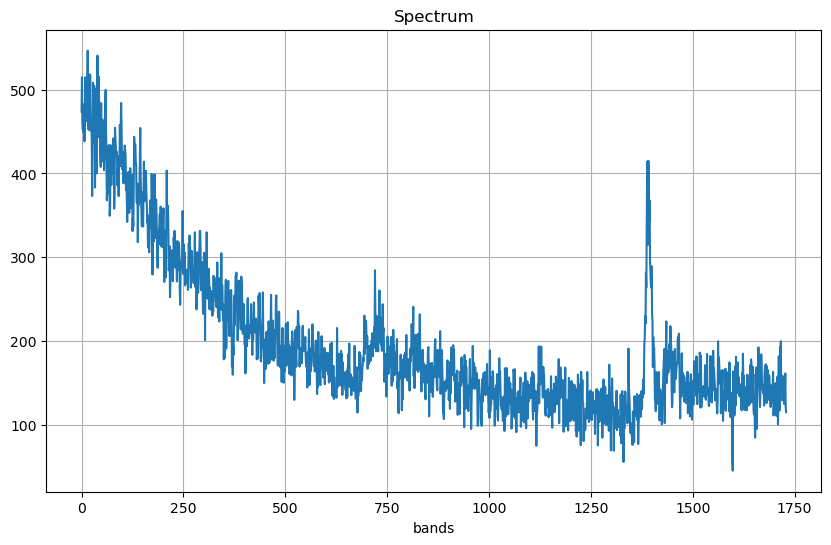

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(HS_image[35, 42, :])
plt.title('Spectrum')
plt.xlabel('bands')

plt.grid(True)
plt.show()

In [6]:
# first we are going to flatten the data to get an array with shape (n_pixels, n_bands)
HS_image_flat = HS_image.reshape(-1, n_bands)


In [7]:
print("Shape of the hyperspectral image:", HS_image_flat.shape)  # (n_pixels, n_bands)

Shape of the hyperspectral image: (7000, 1730)


We have seen on the slide that the interesting part is between 500 and 800 eV, so we are going to crop the spectra

In [8]:
HS_image_cropped = HS_image_flat[:, 500:1650]

In [9]:
# Let's check the new shape

print("Shape of the hyperspectral image:", HS_image_cropped.shape)  # (n_pixels, n_bands)

Shape of the hyperspectral image: (7000, 1150)


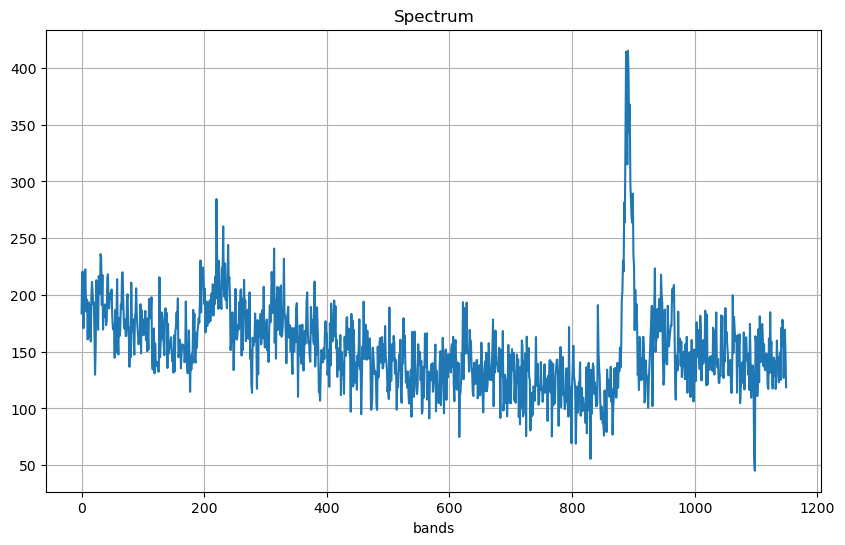

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(HS_image_cropped[3542, :])
plt.title('Spectrum')
plt.xlabel('bands')

plt.grid(True)
plt.show()

## 1. Principal Component Analysis with Hyperspy implementation  

HyperSpy can “normalize” the data by performing a scaling operation, which can greatly enhance the result. More details about the normalization procedure can be found in:  
M. Keenan and P. Kotula, “Accounting for Poisson noise in the multivariate analysis of ToF-SIMS spectrum images,” Surf. Interface Anal 36(3) (2004): 203–212 [https://onlinelibrary.wiley.com/doi/10.1002/sia.1657].

In [11]:
# first we have to eliminate negative values
if np.min(HS_image) < 0:
    HS_image -= np.min(HS_image)

# then we convert the numpy array into Hyperspy format
HS_hyp_image = hs.signals.Signal1D(HS_image)

HS_hyp_image

<Signal1D, title: , dimensions: (100, 70|1730)>

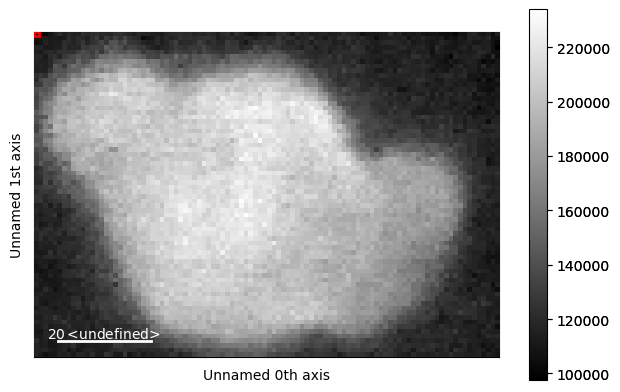

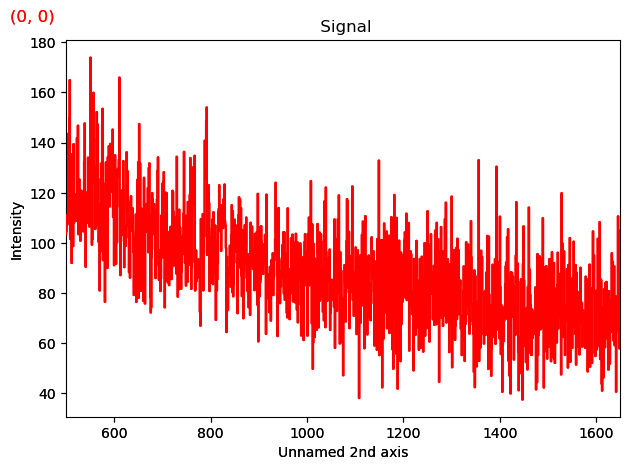

In [12]:
# we crop some energy bands
HS_hyp_image_crop = HS_hyp_image.isig[500:1650]

# we can plot the data
HS_hyp_image_crop.plot()

In [13]:
# we perform the pca decomposition
HS_hyp_image_crop.decomposition(True)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


In [14]:
# extract variance from hyperspy
# Compute the fraction of total variance explained by each principal component
hyperspy_variance_hypspy = HS_hyp_image_crop.get_explained_variance_ratio()
hyperspy_variance = hyperspy_variance_hypspy.data

# Compute the cumulative sum of explained variance to assess how many components
# are needed to reach a desired level (e.g., 95%) of total variance
hyperspy_cumulative = np.cumsum(hyperspy_variance)

⚠️ Note on Hyperspy syntax:
Retrieving certain variables (such as explained variance or loadings) in Hyperspy can be unintuitive, as the syntax and object structure differ significantly from common libraries like scikit-learn.


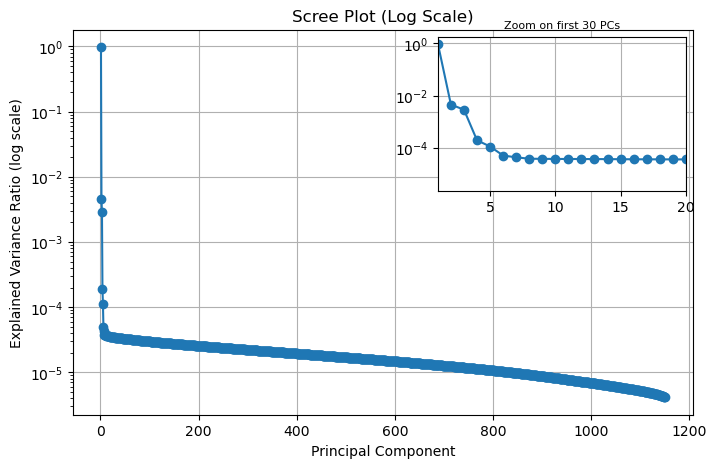

In [15]:
#This plot shows how much variance each principal component explains.
#Most of the meaningful signal is usually captured by the first few components, as shown by the steep initial drop in the scree plot.
#The “elbow” in the curve helps determine where to stop — components beyond that point mainly capture noise.
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.figure(figsize=(8, 5))
plt.semilogy(
    np.arange(1, len(hyperspy_variance) + 1),
    hyperspy_variance,
    marker='o'
)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio (log scale)')
plt.title('Scree Plot (Log Scale)')
plt.grid(True)

# Création de l'inset (zoom sur les 20 premiers composants)
ax_inset = inset_axes(plt.gca(), width="40%", height="40%", loc="upper right")
ax_inset.semilogy(
    np.arange(1, len(hyperspy_variance) + 1),
    hyperspy_variance,
    marker='o'
)
ax_inset.set_xlim(1, 20)
ax_inset.set_title("Zoom on first 30 PCs", fontsize=8)
ax_inset.grid(True)

plt.show()


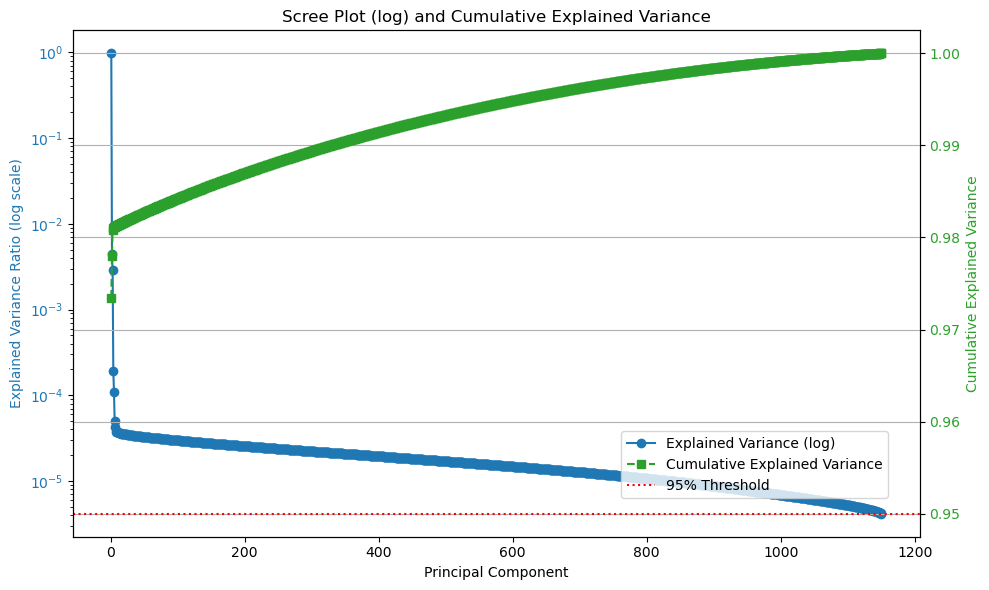

In [16]:
# Plot both the explained variance (scree plot, log scale, left axis) and the cumulative variance (linear scale, right axis)
# on the same graph to visualize how information is distributed across components
# The log-scale scree plot helps visualize these small contributions that are otherwise invisible on a linear scale.

fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis : scree plot with log scale
color1 = 'tab:blue'
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio (log scale)', color=color1)
ax1.semilogy(np.arange(1, len(hyperspy_variance) + 1),
             hyperspy_variance,
             marker='o',
             linestyle='-',
             color=color1,
             label='Explained Variance (log)')
ax1.tick_params(axis='y', labelcolor=color1)

# Right axis  : cumulated variance with linear scale
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Cumulative Explained Variance', color=color2)
ax2.plot(np.arange(1, len(hyperspy_cumulative) + 1),
         hyperspy_cumulative,
         marker='s',
         linestyle='--',
         color=color2,
         label='Cumulative Explained Variance')
ax2.axhline(y=0.95, color='red', linestyle=':', label='95% Threshold')
ax2.tick_params(axis='y', labelcolor=color2)

# Légendes
fig.legend(loc='lower right', bbox_to_anchor=(0.9, 0.15))
plt.title('Scree Plot (log) and Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()


We observe that the first PCA component already explains most of the variance — but that variance mostly corresponds to the decaying background. The chemically relevant information lies in the weaker (5-6) components that follow.

In [17]:
# we will reiterate the decomposition without the option "normalize_poissonian_noise"
HS_hyp_image_crop2 = HS_hyp_image.isig[500:1650]
# we perform the pca decomposition
HS_hyp_image_crop2.decomposition()

hyperspy_variance_hypspy2 = HS_hyp_image_crop2.get_explained_variance_ratio() 
hyperspy_variance2 = hyperspy_variance_hypspy2.data
hyperspy_cumulative2 = np.cumsum(hyperspy_variance2)


Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None


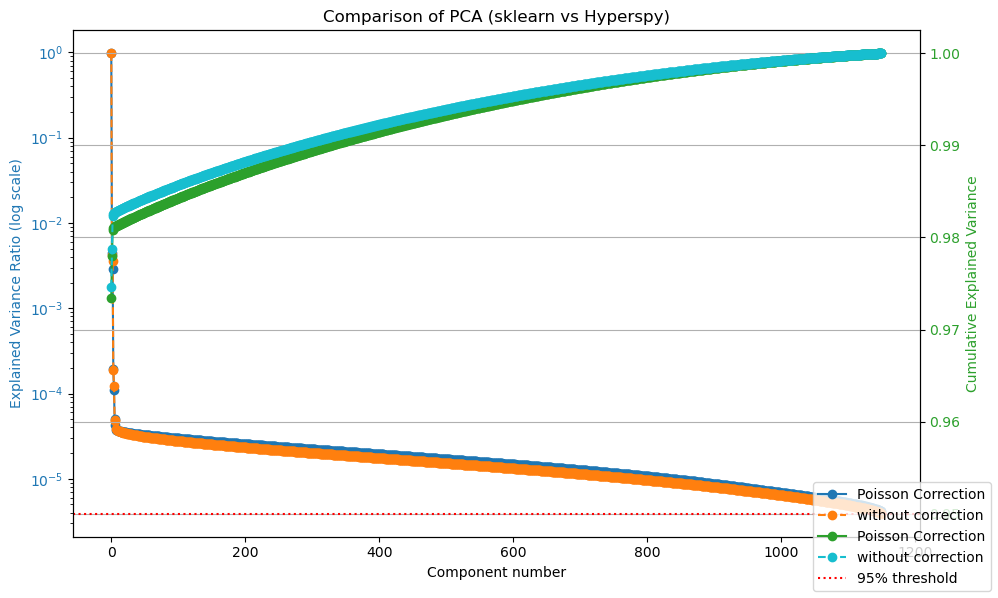

In [18]:


# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis : scree plot with log scale
ax1.set_xlabel("Component number")
ax1.set_ylabel("Explained Variance Ratio (log scale)", color='tab:blue')
ax1.semilogy(hyperspy_variance, label='Poisson Correction', color='tab:blue', marker='o', linestyle='-')
ax1.semilogy(hyperspy_variance2, label='without correction', color='tab:orange', marker='o', linestyle='--')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right axis  : cumulated variance with linear scale
ax2 = ax1.twinx()
ax2.set_ylabel("Cumulative Explained Variance", color='tab:green')
ax2.plot(hyperspy_cumulative, label='Poisson Correction', color='tab:green', marker='o',linestyle='-')
ax2.plot(hyperspy_cumulative2, label='without correction', color='tab:cyan', marker='o',linestyle='--')
ax2.axhline(y=0.95, color='red', linestyle=':', label='95% threshold')
ax2.tick_params(axis='y', labelcolor='tab:green')


fig.legend(loc='lower right')
plt.title("Comparison of PCA (sklearn vs Hyperspy)")
plt.grid(True)
plt.tight_layout()
plt.show()


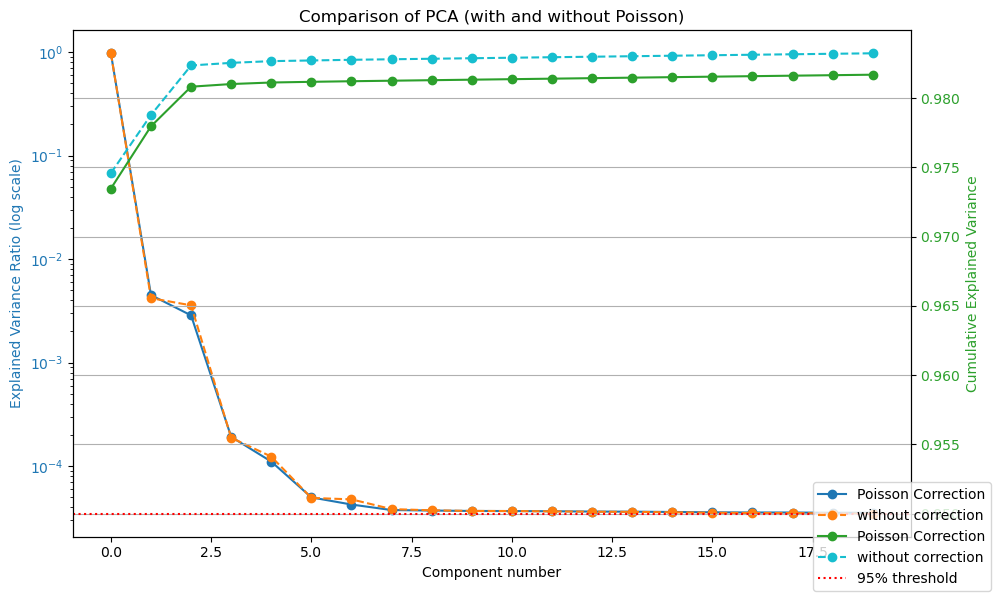

In [19]:
# Zoom on the first components
fig, ax1 = plt.subplots(figsize=(10, 6))

# Left axis : scree plot with log scale
ax1.set_xlabel("Component number")
ax1.set_ylabel("Explained Variance Ratio (log scale)", color='tab:blue')
ax1.semilogy(hyperspy_variance[:20], label='Poisson Correction', color='tab:blue', marker='o', linestyle='-')
ax1.semilogy(hyperspy_variance2[:20], label='without correction', color='tab:orange', marker='o', linestyle='--')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right axis  : cumulated variance with linear scale
ax2 = ax1.twinx()
ax2.set_ylabel("Cumulative Explained Variance", color='tab:green')
ax2.plot(hyperspy_cumulative[:20], label='Poisson Correction', color='tab:green', marker='o',linestyle='-')
ax2.plot(hyperspy_cumulative2[:20], label='without correction', color='tab:cyan', marker='o',linestyle='--')
ax2.axhline(y=0.95, color='red', linestyle=':', label='95% threshold')
ax2.tick_params(axis='y', labelcolor='tab:green')


fig.legend(loc='lower right')
plt.title("Comparison of PCA (with and without Poisson)")
plt.grid(True)
plt.tight_layout()
plt.show()

In this example, enabling the Poissonian noise correction option in HyperSpy does not significantly change the results.  
Indeed, in EELS the total counts is relatively high and makes the distribution closer to Gaussian due to the central limit theorem. As a consequence, the difference between assuming pure Poisson statistics and Gaussian-like noise becomes small, and the correction has little practical effect.

Now we have performed a satisfying decomposition let's give a look at the output.  
 
Indeed visual inspection remains an essential step in evaluating PCA decomposition results.
It allows us to quickly identify components that exhibit:
- meaningful spectral features (in the factors),
- clear spatial structures (in the loadings),
and to distinguish them from noise-dominated components that lack interpretability.

🔄 HyperSpy uses the convention ‘factors = spectra’ and ‘loadings = spatial maps’. In other libraries (e.g. scikit-learn), the opposite terminology may be used (‘loadings = spectra’, ‘scores/factors = maps’).

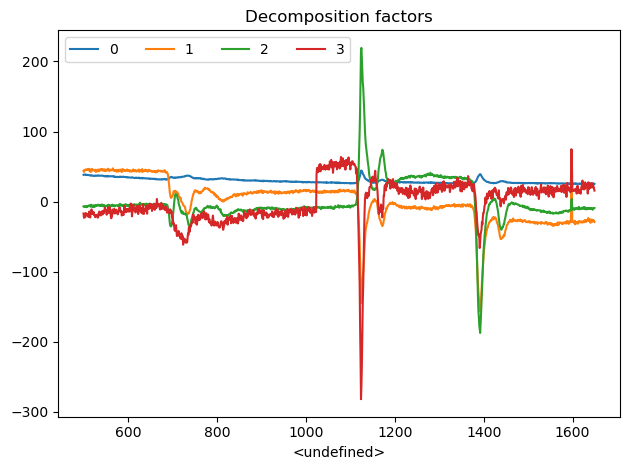

In [20]:
# Display the first 4 factors to keep the figure readable.
# These components clearly show distinct spectral features.
HS_hyp_image_crop.plot_decomposition_factors(4);

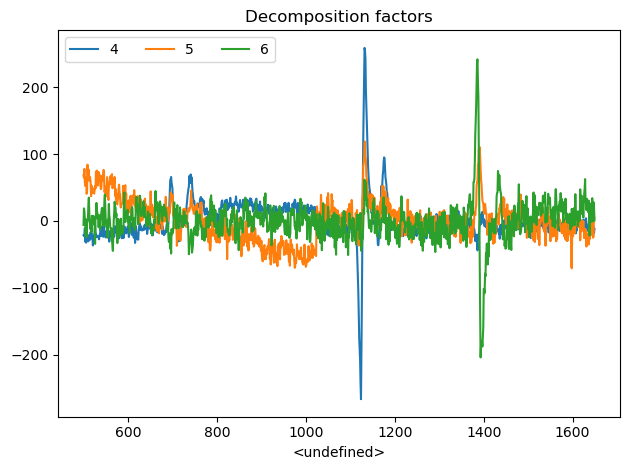

In [21]:
# The next 3 components (factors 5 to 7) still contain some structured signal,
# possibly corresponding to weaker phases or experimental variations.
HS_hyp_image_crop.plot_decomposition_factors([4, 5, 6]);

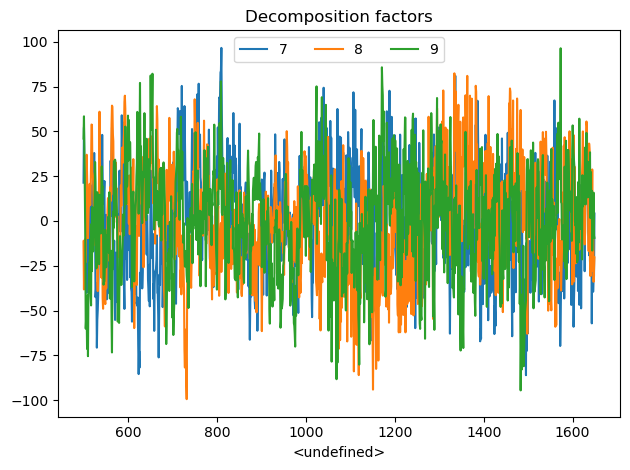

In [22]:
# Beyond component 6, the remaining factors mostly contain noise
# and do not contribute meaningful information.
HS_hyp_image_crop.plot_decomposition_factors([7, 8, 9]);

Let's look at the "loadings". The first 5 loadings show clear spatial patterns associated with the main spectral components.
Loadings 5 to 6 still display some structure and may correspond to minor phases or gradients.
Higher-order loadings mostly appear noisy, indicating that they likely capture background variation or measurement noise.

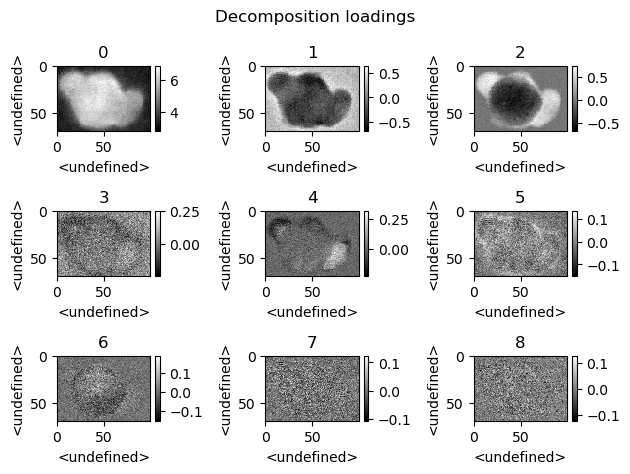

In [23]:
HS_hyp_image_crop.plot_decomposition_loadings(9);

Now we will save a reduced representation of the data set as a numpy array for further analysis (clustering).

In [24]:
# Extract the spatial loadings (i.e., projection of each pixel in the reduced component space)
reduced_coords = HS_hyp_image_crop.get_decomposition_loadings().data

In [25]:
# we check the dimensions
print(reduced_coords.shape)

(1150, 70, 100)


In [26]:
# we keep only 7 components
X_reduced = reduced_coords[:7, :, :].transpose(1, 2, 0)

# This gives a 3D array of shape (n_components, n_rows, n_cols)
print(X_reduced.shape)

# X_reduced is suitable for clustering algorithms such as KMeans or HDBSCAN
# we save it for future use.
np.save("MnOFeO_NP_coreLoss_reduced_70x100x7.npy", X_reduced)

(70, 100, 7)


## 2. Dimensionality reduction: UMAP - Going Beyond Linearity

The UMAP method (Uniform Manifold Approximation and Projection) is an unsupervised dimensionality reduction technique used to explore and visualize complex data in high-dimensional spaces, while preserving both the local and global structure of the data.  

It is designed to be compatible with scikit-learn, making use of the same API and able to be added to sklearn pipelines.  
📦 UMAP is not included in scikit and you have to install it separately.

UMAP has several hyperparameters that can significantly influence the resulting embedding. This makes it particularly sensitive to tuning.
In our case, the challenge is compounded by the difficulty of deciding on a meaningful target dimension: unlike PCA, UMAP does not provide a straightforward criterion such as explained variance to guide this choice.
As a result, applying UMAP to our data is quite touchy, and careful empirical testing is required to obtain a usable projection.
The four major parameters are 

    n_neighbors

    min_dist

    n_components

    metric




In [27]:
from umap import UMAP
import plotly.express as px # for data visualization

In [28]:
# we will use the "flatten" image with 7000 pixels and 1150 energy bands
HS_image_cropped.shape

(7000, 1150)

In [29]:
# apply UMAP with default values for the hyperparameters

umap_model = UMAP(
    n_neighbors=15,   # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
    min_dist=0.1,    # default 0.1, The effective minimum distance between embedded points.
    metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
    n_components=2 , # default 2, The dimension of the space to embed into.
    spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
)
image_umap = umap_model.fit_transform(HS_image_cropped)

C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [30]:
# Check the shape of the new data
print('Shape of image_umap: ', image_umap.shape)

Shape of image_umap:  (7000, 2)


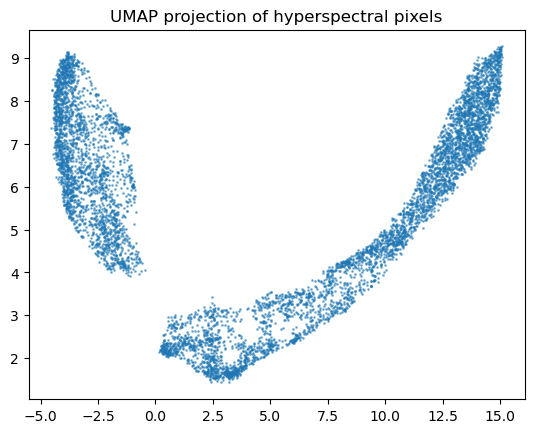

In [31]:
# the pixels can be visualized in the embedding space

plt.scatter(image_umap[:, 0], image_umap[:, 1], s=1, alpha=0.5)
plt.title("UMAP projection of hyperspectral pixels")
plt.show()

UMAP creates a low-dimensional embedding where the coordinates are meaningful only in combination and not as separate axes.
The output of UMAP consists solely of the embedding coordinates for each data point, without any associated loadings or explained variance.  

As a result, one of the main difficulties with UMAP is the lack of a clear criterion to determine whether a given choice of parameters (e.g., number of components, number of neighbors, or minimum distance) is more appropriate than another.
The quality of the embedding must be evaluated empirically, often based on visual inspection or downstream task performance (e.g., clustering quality), which makes tuning subjective and data-dependent.  

For now, we will simply visualize how certain UMAP parameters affect the spatial distribution of the embedded pixels.  
from https://umap-learn.readthedocs.io/en/latest/parameters.html

### 2.1 n_neighbors

`n_neighbors` controls how UMAP balances local versus global structure in the data.

We can see that in practice by fitting our dataset with UMAP using a range of n_neighbors values. The default value of n_neighbors for UMAP (as used above) is 15, but we will look at values ranging from 2 (a very local view of the manifold) up to 200 (a quarter of the data).

C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed

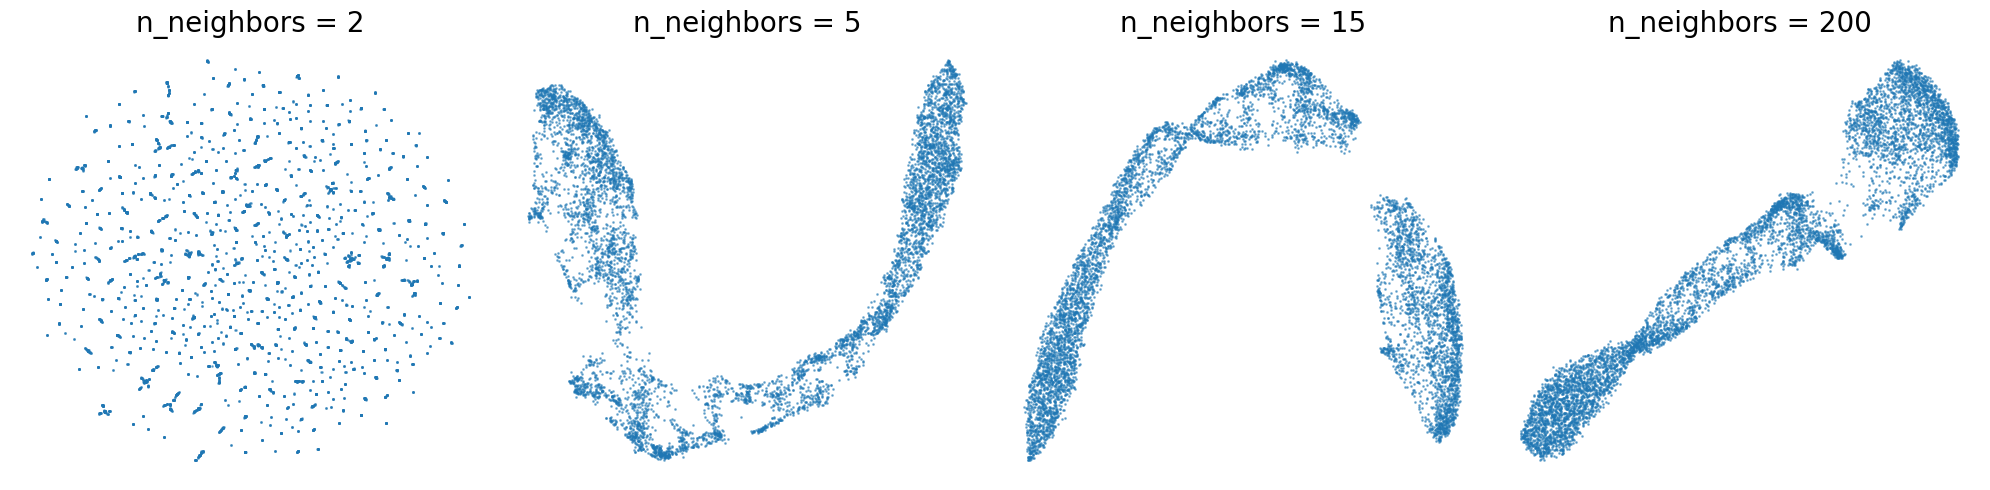

In [32]:
# List of n_neighbors values we want to test
n_neighbors_list = [2, 5, 15, 200]


# creation of the plot
fig, axs = plt.subplots(1, len(n_neighbors_list), figsize=(5 * len(n_neighbors_list), 5))

# loop on n_neighbors values
for i, n in enumerate(n_neighbors_list):
    reducer = UMAP(n_neighbors=n, n_components=2)
    X_umap = reducer.fit_transform(HS_image_cropped)
    axs[i].scatter(X_umap[:, 0], X_umap[:, 1], s=1, alpha=0.5)
    axs[i].set_title(f'n_neighbors = {n}', fontsize=20)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


### 2.2 min_dist  

The `min_dist` parameter controls how tightly UMAP is allowed to pack points together.Low values of min_dist can be useful if you are interested in clustering, or in finer topological structure. Larger values of min_dist will focus on the preservation of the broad topological structure instead.

The default value for `min_dist` (as used above) is 0.1. We will look at a range of values from 0.0 through to 0.99.

C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


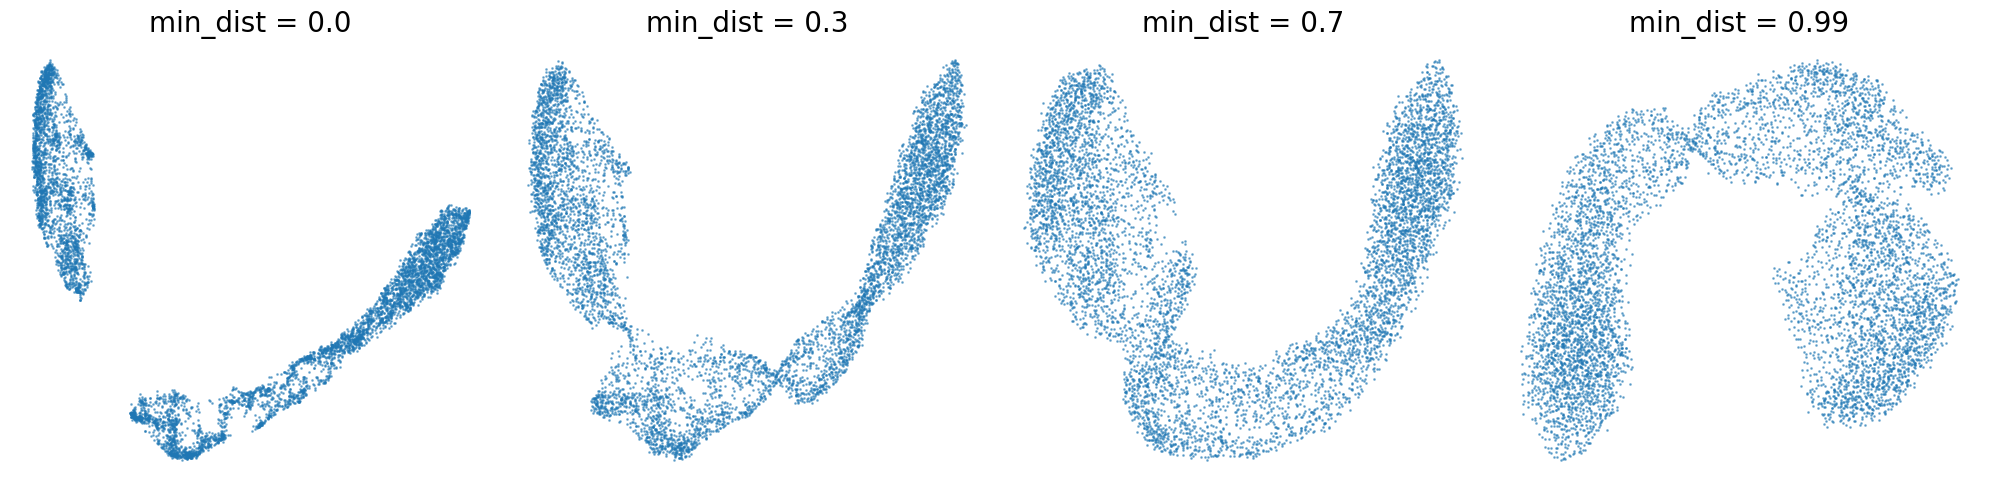

In [33]:
# List of n_neighbors values we want to test
min_dist_list = [0.0, 0.3, 0.7, 0.99]

# creation of the plot
fig, axs = plt.subplots(1, len(min_dist_list), figsize=(5 * len(min_dist_list), 5))

# loop on n_neighbors values
for i, n in enumerate(min_dist_list):
    reducer = UMAP(min_dist=n, n_components=2)
    X_umap = reducer.fit_transform(HS_image_cropped)
    axs[i].scatter(X_umap[:, 0], X_umap[:, 1], s=1, alpha=0.5)
    axs[i].set_title(f'min_dist = {n}', fontsize=20)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


### 2.3 metric 

The `metric` parameter controls how distance is computed in the ambient space of the input data. By default UMAP supports a wide variety of metrics.




C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env

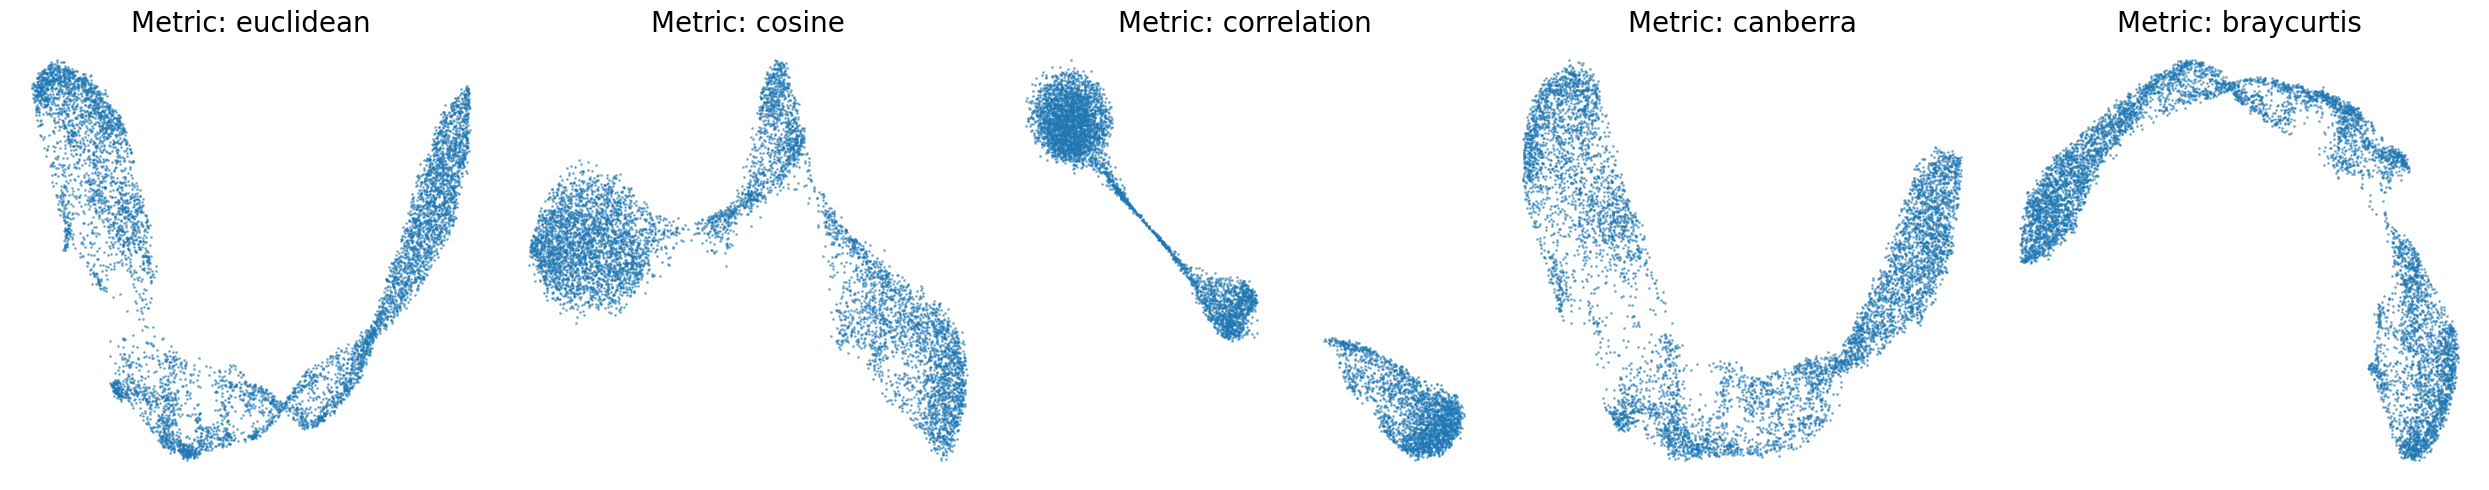

In [34]:
metrics_to_test = ["euclidean", "cosine", "correlation", "canberra", 'braycurtis']

fig, axs = plt.subplots(1, len(metrics_to_test), figsize=(5 * len(metrics_to_test), 5))

for i, metric in enumerate(metrics_to_test):
    reducer = UMAP(n_neighbors=15, metric=metric)
    X_umap = reducer.fit_transform(HS_image_cropped)

    axs[i].scatter(X_umap[:, 0], X_umap[:, 1], s=1, alpha=0.5)
    axs[i].set_title(f'Metric: {metric}', fontsize=20)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

### 2.4 n_components  

`n_components` parameter allows the user to determine the dimensionality of the reduced dimension space we will be embedding the data into. Unlike some other visualisation algorithms such as t-SNE, UMAP scales well in the embedding dimension, so you can use it for more than just visualisation in 2- or 3-dimensions.

For the purposes of this demonstration (so that we can see the effects of the parameter) we will only be looking at 1-dimensional and 3-dimensional embeddings, which we have some hope of visualizing.

First of all we will set `n_components` to 1, forcing UMAP to embed the data in a line. For visualisation purposes we will randomly distribute the data on the y-axis to provide some separation between points.


In [35]:
def draw_umap_row(data, color_labels=None, n_neighbors=15, min_dist=0.1, 
                  metric='euclidean', title_prefix='UMAP projection'):
    fig = plt.figure(figsize=(15, 4))

    for i, n_comp in enumerate([1, 2, 3]):
        reducer = UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=n_comp,
            metric=metric
        )
        embedding = reducer.fit_transform(data)

        ax = fig.add_subplot(1, 3, i+1, projection='3d' if n_comp == 3 else None)
        if n_comp == 1:
            ax.scatter(embedding[:, 0], range(len(embedding)), 
                       c=color_labels if color_labels is not None else 'blue', s=1)
            ax.set_ylabel("Index")
            ax.set_xlabel("UMAP-1")
        elif n_comp == 2:
            ax.scatter(embedding[:, 0], embedding[:, 1], 
                       c=color_labels if color_labels is not None else 'blue', s=1)
            ax.set_xlabel("UMAP-1")
            ax.set_ylabel("UMAP-2")
        else:  # n_comp == 3
            ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2],
                       c=color_labels if color_labels is not None else 'blue', s=1)
            ax.set_xlabel("UMAP-1")
            ax.set_ylabel("UMAP-2")
            ax.set_zlabel("UMAP-3")
        
        ax.set_title(f"{title_prefix} ({n_comp}D)", fontsize=14)

    plt.tight_layout()
    plt.show()


C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


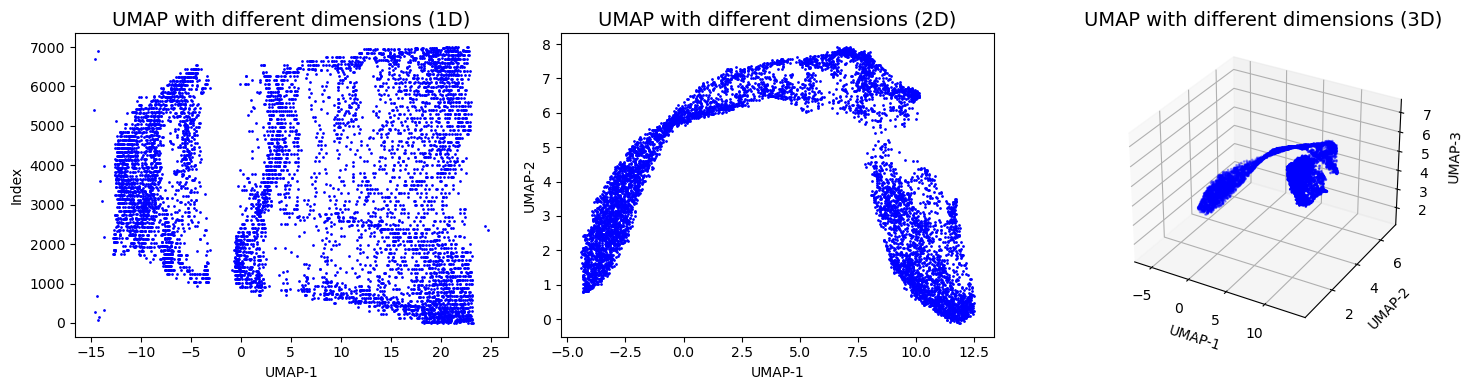

In [36]:
draw_umap_row(HS_image_cropped, title_prefix="UMAP with different dimensions")

As the 3D embedding is not easy to visualize we will use a special mode

In [37]:
umap_model_3D = UMAP(
    n_neighbors=15,   # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
    min_dist=0.1,    # default 0.1, The effective minimum distance between embedded points.
    metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
    n_components=3 , # default 2, The dimension of the space to embed into.
    spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
)
image_umap = umap_model_3D.fit_transform(HS_image_cropped)

C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [38]:
def chart(X, y):
    #--------------------------------------------------------------------------#
    

    # Concatenate X and y arrays
    
    arr_concat=np.concatenate((X, y.reshape(y.shape[0],1)), axis=1)
    # Create a Pandas dataframe using the above array
    df=pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
    # Convert label data type from float to integer
    df['label'] = df['label'].astype(int)
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    #--------------------------------------------------------------------------#

    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', height=900, width=950)

    # Update chart looks
    fig.update_layout(title_text='UMAP',
                      showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))

    fig.show()

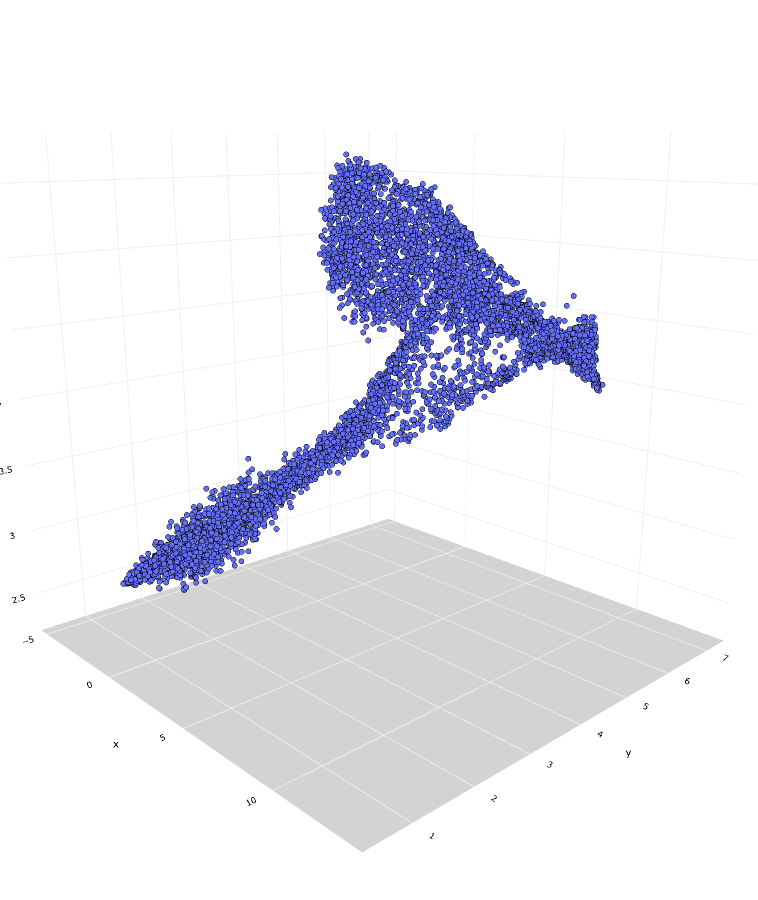

In [39]:
y = np.random.randint(0, 5, size=7000)
chart(image_umap, y)

Now we are going to compare the representation of the data in a 2D space with PCA and UMAP

C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



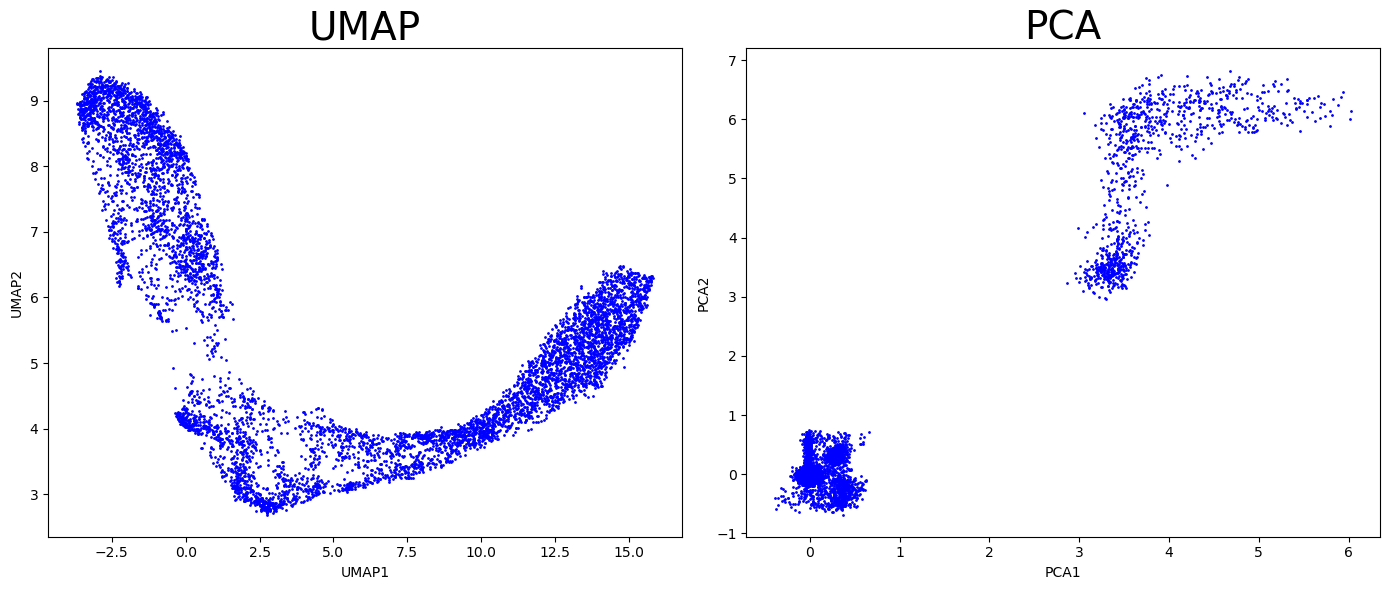

In [40]:
# Apply UMAP
umap_model_2D = UMAP(
    n_neighbors=15,   # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
    min_dist=0.1,    # default 0.1, The effective minimum distance between embedded points.
    metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
    n_components=2 , # default 2, The dimension of the space to embed into.
    spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
)
image_umap = umap_model_3D.fit_transform(HS_image_cropped)


# we get PCA results from Part 1
pca_result = X_reduced.reshape(7, -1).T 


fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# UMAP
ax[0].scatter(image_umap[:, 0], image_umap[:, 1], c='blue', s=1)
ax[0].set_title('UMAP', fontsize = 28)
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')

# PCA
ax[1].scatter(pca_result[:, 0], pca_result[:, 1], c='blue', s=1)
ax[1].set_title('PCA', fontsize = 28 )
ax[1].set_xlabel('PCA1')
ax[1].set_ylabel('PCA2')


plt.tight_layout()
plt.show()


### 2.5 Conclusions  

In conclusion, selecting the appropriate hyperparameters for UMAP remains quite perplexing. The effect of different choices (e.g., number of neighbors or distance metric) can drastically change the embedding, and there is no straightforward way to determine which setting is best.  
In many educational presentations, UMAP is demonstrated on labeled datasets — which makes the task of dimensionality reduction much easier, since the desired outcome is already known.  
In real-world, with unlabeled data, the lack of ground truth makes both parameter tuning and interpretation much more challenging.  

In a second notebook, we will evaluate how well these embeddings support clustering, which may help us decide which configurations are more meaningful for our data.

## 3. Dimensionality reduction: t-SNE  
t-SNE (t-distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction technique particularly well-suited for visualizing high-dimensional data in 2 or 3 dimensions. It preserves local structure by modeling pairwise similarities, making it effective for revealing clusters and patterns.  
📦 t-SNE is implemented in scikit.  
 While t-SNE is excellent for visualizing high-dimensional data by preserving local relationships, it is not ideal as a preprocessing step for clustering. This is because t-SNE distorts global structure and does not preserve distances or cluster shapes reliably, which can mislead clustering algorithms like K-means that rely on such structure.  
We briefly present t-SNE here as it is a commonly mentioned algorithm, but we will not use it further in our analysis due to its limitations outside of visualization.


 Several parameters influence the t-SNE optimization process, the most important being perplexity, which loosely controls the balance between local and global structure in the data. It can be interpreted as a guess about the number of close neighbors each point has. Perplexity has a nontrivial effect on the resulting embedding: while the original paper claims that t-SNE is fairly robust to this parameter (typically between 5 and 50), the reality is more nuanced. In practice, exploring multiple perplexity values is often necessary to assess the stability and interpretability of the visualization.  

🔄 **Reminder:** t-SNE is much slower than UMAP (O(N²) complexity) and does not scale well to large datasets.

C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.

C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.

C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.

C:\Users\brun\AppData\Local\miniconda3\envs\Hyperspy_env_clone\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



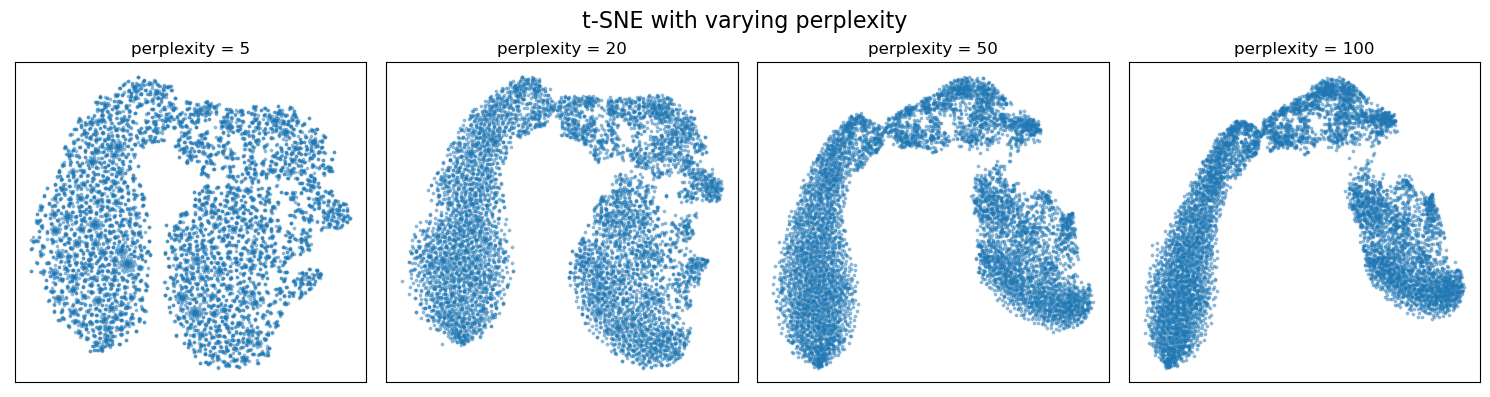

In [41]:
# 🐢 SLOW CELL
param_name = 'perplexity'
param_values = [5, 20, 50, 100]

# Figure
fig, axes = plt.subplots(1, len(param_values), figsize=(15, 4))
fig.suptitle(f't-SNE with varying {param_name}', fontsize=16)

# Loop
for ax, val in zip(axes, param_values):
    tsne_params = {
        'n_components': 2,
        'random_state': 42,
        'init': 'pca',
        'n_iter': 1000
    }
    tsne_params[param_name] = val
    
    embedding = TSNE(**tsne_params).fit_transform(HS_image_cropped)
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], cmap='tab10', s=3, alpha = .4)
    ax.set_title(f"{param_name} = {val}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


## Conclusions  
- **Use PCA with caution**: PCA is a powerful tool for dimensionality reduction, but it assumes linearity in the data. It may not capture complex relationships in non-linear datasets, so it should be used carefully, especially when dealing with high-dimensional or non-linear data.

- **Use UMAP with extra caution**: UMAP is a non-linear method that preserves both local and global structures well. However, it can be sensitive to hyperparameter settings such as n_neighbors and min_dist. It is recommended to tune these parameters carefully and validate the results before drawing conclusions.

- **Use t-SNE for visualization only**: t-SNE is excellent for visualizing data in 2D or 3D, especially when dealing with complex, non-linear relationships. However, it should be used only for visualization purposes, as it is not a general-purpose dimensionality reduction technique and can distort the global structure of the data.